In [17]:
import numpy as np
import pandas as pd

import jax.numpy as jnp
from scipy.sparse.linalg import eigsh

from netket.graph import Hypercube
from netket.hilbert import Spin
from netket.operator import Ising, LocalOperator

import matplotlib.pyplot as plt


SIDE_LENGTH = 3

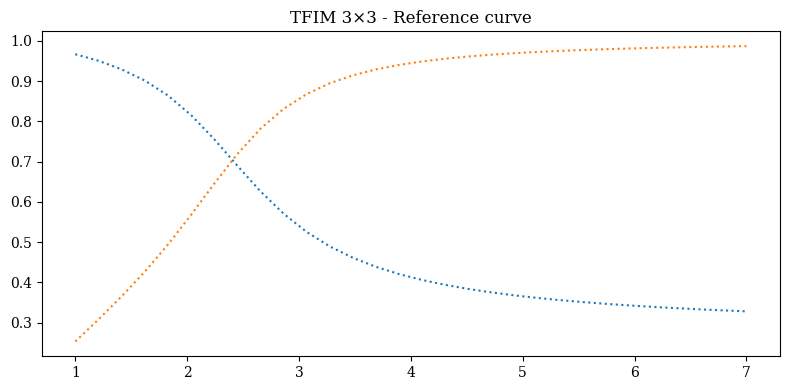

In [18]:
# generate a reference curve for 3x3 TFIM

def calculate_groundstate(hamiltonian: LocalOperator):
    eigvals, eigvecs = eigsh(hamiltonian.to_sparse(), k=1, which="SA")
    return eigvals[0], jnp.array(eigvecs[:, 0], dtype=jnp.complex64)


def magnetization_z_spontaneous(state: jnp.ndarray) -> jnp.ndarray:
    state_size = state.shape[0]
    n = int(jnp.log2(state_size))
    assert 2**n == state_size, "State length must be a power of 2."
    probs = jnp.abs(state) ** 2
    basis = jnp.arange(state_size)
    bits = (basis[:, None] >> jnp.arange(n)[::-1]) & 1
    spins = 1.0 - 2.0 * bits                  # ±1
    m_vec = jnp.abs(spins.mean(axis=1))       # spontaneous (absolute)
    return jnp.sum(probs * m_vec)


def overlap_after_spin_flip(state: jnp.ndarray, n: int, flip_idx: int):
    idx = jnp.arange(2**n)
    flipped = idx ^ (1 << (n - 1 - flip_idx))
    return jnp.vdot(state, state[flipped]).real


def magnetization_x_from_state(state: jnp.ndarray):
    n = int(jnp.log2(state.shape[0]))
    overlaps = jnp.array([overlap_after_spin_flip(state, n, i) for i in range(n)])
    return overlaps.mean()


# sweep (2D TFIM on 3×3 with PBC)
graph = Hypercube(length=SIDE_LENGTH, n_dim=2, pbc=True)
hilbert = Spin(s=0.5, N=graph.n_nodes)


def sweep_magnetization(h_min=1.0, h_max=7.0, num_points=30):
    h_vals = jnp.linspace(h_min, h_max, num_points)
    mz_vals, mx_vals = [], []
    for h in h_vals:
        ham = Ising(hilbert, graph, h=float(h), J=-1.0)  # ferro TFIM
        _, state = calculate_groundstate(ham)
        mz_vals.append(magnetization_z_spontaneous(state))
        mx_vals.append(magnetization_x_from_state(state))
    return h_vals, jnp.array(mz_vals), jnp.array(mx_vals)


h_vals_ref, mz_ref, mx_ref = sweep_magnetization()


plt.figure(figsize=(8, 4))
plt.plot(h_vals_ref, mz_ref, linestyle=":")
plt.plot(h_vals_ref, mx_ref, linestyle=":")
plt.title(f"TFIM {SIDE_LENGTH}×{SIDE_LENGTH} - Reference curve")
plt.tight_layout()
plt.show()

In [19]:
# load datapoints from csv

file_name = "magnetization.csv"
df = pd.read_csv(file_name)

# ensure numeric dtypes for plotting (no error columns)
for col in ["h", "mag_z", "mag_x"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df_support = df[df["type"] == "support"].sort_values("h").reset_index(drop=True)
df_novel = df[df["type"] == "novel"].sort_values("h").reset_index(drop=True)

h_vals_rbm  = df_support["h"].to_numpy()
magnetizations_z_rbm = df_support["mag_z"].to_numpy()
magnetizations_x_rbm = df_support["mag_x"].to_numpy()

h_vals_rbm_generated  = df_novel["h"].to_numpy()
magnetizations_z_rbm_novel = df_novel["mag_z"].to_numpy()
magnetizations_x_rbm_novel = df_novel["mag_x"].to_numpy()


display_cols = [c for c in ["type", "h", "mag_z", "mag_x"] if c in df.columns]
df_preview = df[display_cols].sort_values(["h"]).reset_index(drop=True)
df_preview.head()

,type,h,mag_z,mag_x
0,support,1.0,0.964333,0.262176
1,novel,1.5,0.947267,0.310387
2,support,2.0,0.831978,0.541445
3,novel,2.4,0.710867,0.697065
4,novel,2.6,0.643044,0.768639


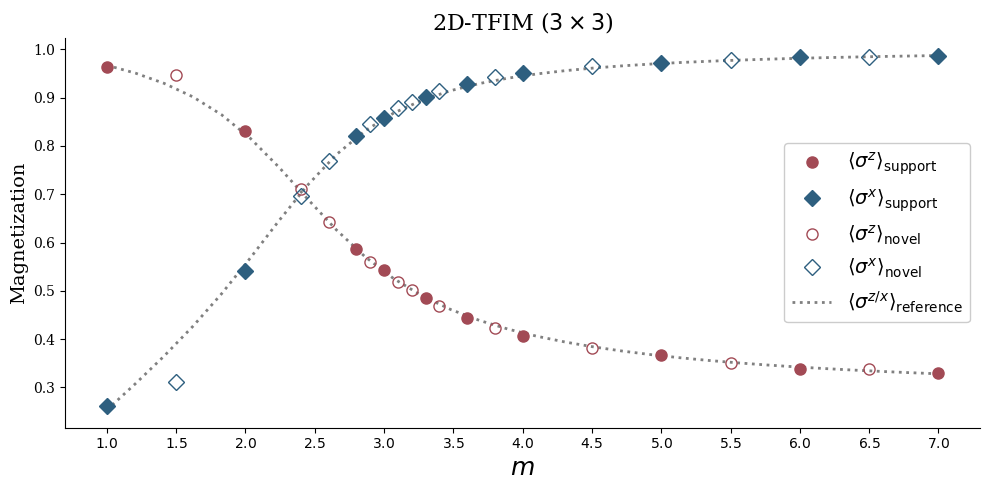

In [20]:
# final curve

english_red = '#a24a55'
bdazzled_blue = '#2e5f7f'
plt.rcParams.update({"font.family": "serif"})

fig, ax = plt.subplots(figsize=(10, 5), facecolor='white')
ax.set_facecolor('white')

# reference curves
ax.plot(h_vals_ref, mz_ref, ':', color='gray', linewidth=2.0, label='_nolegend_', zorder=1)
ax.plot(h_vals_ref, mx_ref, ':', color='gray', linewidth=2.0, label='_nolegend_', zorder=1)

# support points
ax.plot(h_vals_rbm, magnetizations_z_rbm, 'o', color=english_red, markersize=8,
        label=r'$\langle \sigma^z \rangle_{\mathrm{support}}$', zorder=2)
ax.plot(h_vals_rbm, magnetizations_x_rbm, 'D', color=bdazzled_blue, markersize=8,
        label=r'$\langle \sigma^x \rangle_{\mathrm{support}}$', zorder=2)

# novel points
ax.plot(h_vals_rbm_generated, magnetizations_z_rbm_novel, 'o', markerfacecolor='none', markeredgecolor=english_red,
        markersize=8, label=r'$\langle \sigma^z \rangle_{\mathrm{novel}}$', zorder=2)
ax.plot(h_vals_rbm_generated, magnetizations_x_rbm_novel, 'D', markerfacecolor='none', markeredgecolor=bdazzled_blue,
        markersize=8, label=r'$\langle \sigma^x \rangle_{\mathrm{novel}}$', zorder=2)

# proxy curve for both reference lines in legend
ax.plot([], [], ':', color='gray', linewidth=2.0, label=r'$\langle \sigma^{z/x}\rangle_{\mathrm{reference}}$')


ax.set_xlabel('$m$', fontsize=18)
ax.set_ylabel('Magnetization', fontsize=14)
ax.set_title(r"2D-TFIM ($3 \times 3$)", fontsize=16)

h_min, h_max = min(h_vals_ref), max(h_vals_ref)
xticks = np.arange(np.floor(h_min * 2) / 2, np.ceil(h_max * 2) / 2 + 0.01, 0.5)
ax.set_xticks(xticks)
ax.set_xticklabels([f"${x:.1f}$" for x in xticks])

ax.legend(frameon=True, framealpha=1, loc='best', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('tfim_magnetization_highres.png', dpi=300)
plt.show()